In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chisquare
from scipy.stats import normaltest
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from math import exp

**Задание 1**

Проанализировать набор данных и ответить на следующие вопросы:

1) Какой % наблюдений выходит за 5 и 95 перцентиль?

2) Какому закону распределения отвечают данные? На основе чего вы так решили?

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

Описание данных:

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

Значения 5-го и 95-го перцентиля:  [ 1. 52.]
Процент элементов строго меньше 5-го перцентиля: 0.0
Процент элементов строго больше 95-го перцентиля: 4.987306046493438


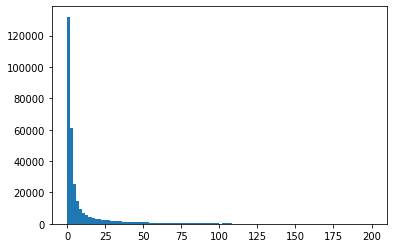

In [2]:
data1 = pd.read_csv("test_1_1.csv", sep=';', index_col = 'Unnamed: 0')
percentile_values = np.percentile(data1.metrics, [5, 95])
print("Значения 5-го и 95-го перцентиля: ", percentile_values)

count_below_5 = sum(elem < percentile_values[0] for elem in data1.metrics)
count_above_95 = sum(elem > percentile_values[1] for elem in data1.metrics)
print("Процент элементов строго меньше 5-го перцентиля:", count_below_5 * 100.0 / len(data1.metrics))
print("Процент элементов строго больше 95-го перцентиля:", count_above_95 * 100.0 / len(data1.metrics))

plt.hist(data1.metrics, bins=100, range=[0, 200])
plt.show()

1) При недискретном распределении процент наблюдений ниже 5-го перцентиля - ровно 5% по определению. Так же процент наблюдений выше 95-го перцентиля ровно 5%.

В нашем дискретном случае 0% лежат ниже 5-го перцентиля и 4.89% лежат выше 95-го перцентиля.

2)Значения начинаются с +1 и не соответствуют распределению Пуассона (я проверил с помощью хи-квадрат теста). Проверим с помощью хи-квадрат теста следующую гипотезу H_0: распределение выборки удовлетворяет отрицательному биномиальному распределению.

In [3]:
def neg_bin(p, r, length):
    probabilities = []
    term = (1 - p)**r
    for itr in range(length):
        probabilities.append(term)
        term *= (r + itr) / (itr + 1) * p 
    return probabilities

truncated_data = data1[data1.metrics < 101].metrics
mean = np.mean(truncated_data)
var = np.var(truncated_data)

p = 1 - mean / var
r = mean * (1 - p) / p
print("p = ", p)
print("r = ", r)

observed = np.bincount(truncated_data) / np.sum(truncated_data)
observed = np.delete(observed, 0) # удалить данные о кол-ве посчитанных нулей 
expected = np.array(neg_bin(p, r, 100))

print(chisquare(observed, expected))

p =  0.9660447111386593
r =  0.2938593030898325
Power_divergenceResult(statistic=0.7722781312451856, pvalue=1.0)


Гипотеза не отвергнута со статистической значимостью почти 1.0. Критерий применим так как имеется большое число наблюдений в каждом классе ( >= 99)

**Задание 2**

Определить, можно сравнить две представленные выборки t критерием Стьюдента? 

Если нельзя сравнивать t-критерием, то что будем использовать и почему?

Ответ аргументировать и описать 

[Ссылка на данные](https://drive.google.com/file/d/1blvC6TEBWghhVMexjOdoGEjzhZZh3wSy/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

*Вместе с ответом на задание приложить код*

In [4]:
data2 = pd.read_csv("test_1_2.csv", sep=';', index_col = 'Unnamed: 0')
data_a = data2[data2.variant == 'A'].metrics
data_b = data2[data2.variant == 'B'].metrics

print(normaltest(data_a))
print(normaltest(data_b))

NormaltestResult(statistic=109098.627332008, pvalue=0.0)
NormaltestResult(statistic=92329.93783182735, pvalue=0.0)


Видим, что данные не проходят тест на нормальность, что исключает использование t-критерий Стьюдента.

Посмотрим на гистограммы данных:

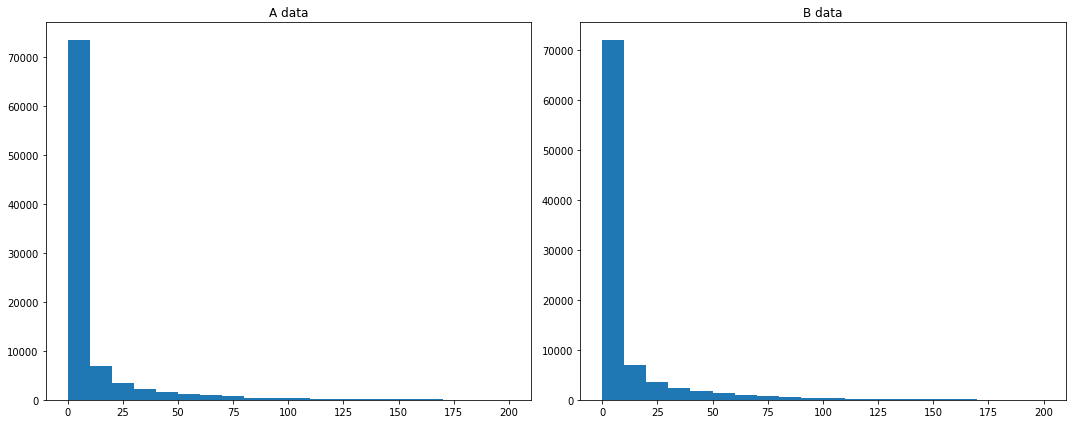

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].hist(data_a, bins = 20, range=[0, 200])
axes[0].title.set_text('A data')

axes[1].hist(data_b, bins = 20, range=[0, 200])
axes[1].title.set_text('B data')

fig.tight_layout()
plt.show()

Они выглядят очень похожими. Попробуем простым хи-квадрат тестом проверить, подходит ли распределение первой под распределение второй.

In [6]:
bincount_a = np.bincount(data_a)[1:100]
bincount_b = np.bincount(data_b)[1:100]

observed = (bincount_a / len(bincount_a))
expected = (bincount_b / len(bincount_b))

chisquare(observed, expected)

Power_divergenceResult(statistic=2.1965523510163383, pvalue=1.0)

Хи-квадрат тест даёт стат значимость 1.0 чтобы не отвергнуть гипотезу о совпадении распределений A и B выборок. Число 100 здесь выбрано так, чтобы для каждого значения имелось > 30 наблюдений. Иначе в теории возможно, что слишком большое количество степеней свободы будет возвращать высокий pvalue даже для несовпадающих распределений. 

Посмотрим также на параметры p, r, так как видно, что распределения, как и в первой задаче,  соответсвуют отрицательному биномиальному.

In [7]:
truncated_data_a = data2[(data2.metrics < 101) & (data2.variant == 'A')].metrics
mean = np.mean(truncated_data_a)
var = np.var(truncated_data_a)

p = 1 - mean / var
r = mean * (1 - p) / p
print("p = ", p)
print("r = ", r)
print("mean = ", mean)
print("var = ", var)

p =  0.966105365920878
r =  0.2891981474650484
mean =  8.243071202012468
var =  243.19693739045047


In [8]:
truncated_data_b = data2[(data2.metrics < 101) & (data2.variant == 'B')].metrics
mean = np.mean(truncated_data_b)
var = np.var(truncated_data_b)

p = 1 - mean / var
r = mean * (1 - p) / p
print("p = ", p)
print("r = ", r)
print("mean = ", mean)
print("var = ", var)

p =  0.9660579855118626
r =  0.2980810109852932
mean =  8.483984976567434
var =  249.95525765073754


Будем использовать другие показатели -- Критерий Манна Уитни Вилкоксона.

In [9]:
print(mannwhitneyu(data_a, data_b, alternative='less'))

MannwhitneyuResult(statistic=4195358346.0, pvalue=1.365559131227319e-05)


Вывод: U-тест даёт pvalue < 0.01 для гипотезы, что метрика на A меньше, чем метрика на B, когда выбирается 2 случайных сэмпла.

Попробуем также непараметрический bootstrap

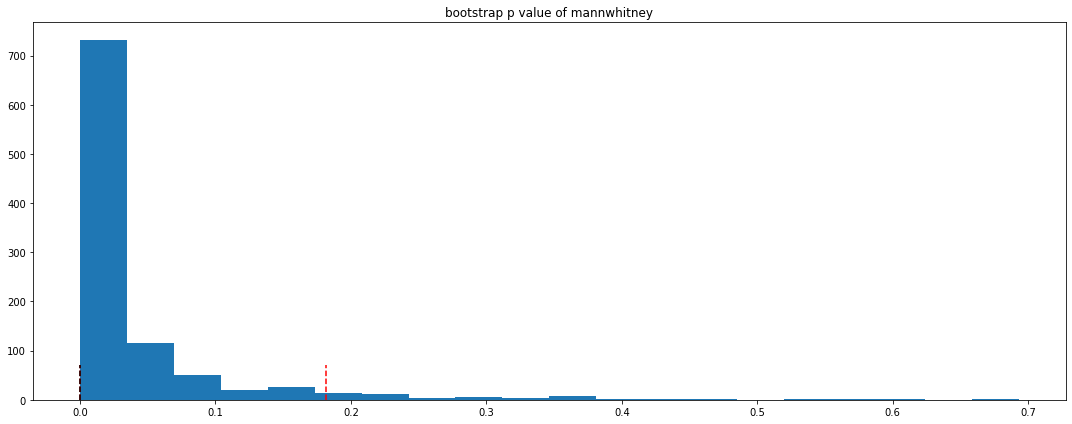

In [10]:
def bootstrap(data_a, data_b, bootstrap_size, n):
    bs = []
    for i in range(n):
        bs_a = np.random.choice(data_a, size=bootstrap_size, replace=True)
        bs_b = np.random.choice(data_b, size=bootstrap_size, replace=True)
        bs.append(mannwhitneyu(bs_a, bs_b, alternative='less')[1])
  
    return bs

bs = bootstrap(truncated_data_a, truncated_data_b, 30000, 1000)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

axes.hist(bs, bins = 20)
axes.title.set_text('bootstrap p value of mannwhitney')
axes.vlines(np.percentile(bs, [5, 95]), ymin=0, ymax=70, linestyles='--', color='r')
axes.vlines(mannwhitneyu(data_a, data_b, alternative='less')[1], ymin=0, ymax=70, linestyles='--', color='black')
fig.tight_layout()
plt.show()

In [11]:
np.percentile(bs, [5, 95])

array([2.06656052e-05, 1.81628314e-01])

Доверительный интервал $\pm$0.05 для p-value оказался [0, 0.248]. Гипотезу в пользу выборки A можно принимать.

**Задание 3**

Дано две выборки по А/Б тесту.

Две выборки несбалансированные - кол-во пользователей в каждой группе разные.

Метрика, которую меряем в эксперименте (и которую используем для определения группы, которая лучше себя показала) - кол-во просмотренных страниц на пользователя 

Как вы будете принимать решение, какая группа лучше А или Б, и какие статистические методы (критерии) вы будете использовать, какие преобразования к данным применять? P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

[Ссылка на данные](https://drive.google.com/file/d/1_g7Dw7-8QzTS47D6GNKMb0FzqMAWBDba/view?usp=sharing)

Описание данных: 

* variant -- вариация в А/Б тесте (либо группа А -- например, сайт без изменений. Либо группа Б -- сайт с изменениями)
* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 


*Вместе с ответом на задание приложить код*

In [0]:
data3 = pd.read_csv("hw2_test_1_3.csv", sep=';', index_col = 'Unnamed: 0')
data_a = data3[data3.variant == 'A'].metrics
data_b = data3[data3.variant == 'D'].metrics

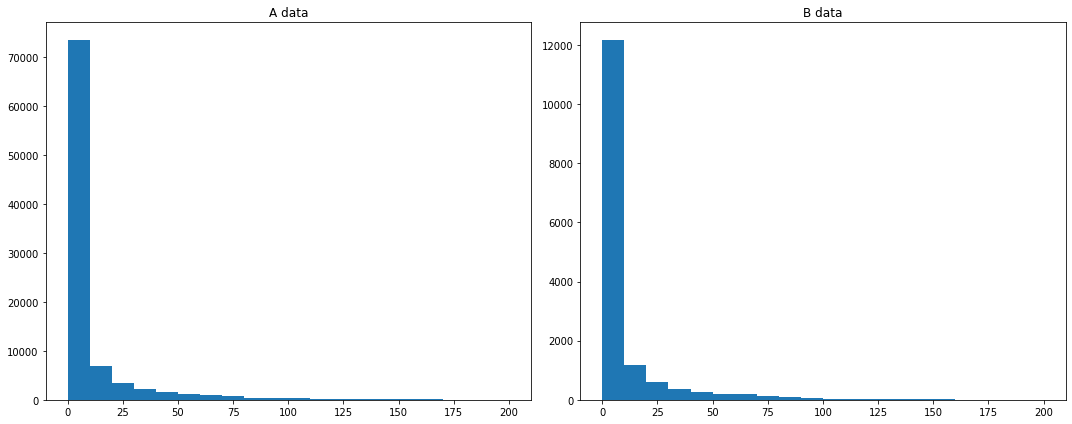

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].hist(data_a, bins = 20, range=[0, 200])
axes[0].title.set_text('A data')

axes[1].hist(data_b, bins = 20, range=[0, 200])
axes[1].title.set_text('B data')

fig.tight_layout()
plt.show()

Рассмотрим перцентили данных:

In [14]:
print('A precentile: ', np.percentile(data_a, [0, 2, 5, 50, 95, 98, 100]))
print('B precentile: ', np.percentile(data_b, [0, 2, 5, 50, 95, 98, 100]))

A precentile:  [  1.   1.   1.   2.  52.  86. 998.]
B precentile:  [  1.   1.   1.   2.  52.  81. 406.]


Видим, что явно имеются выбросы. Отчистим данные, выкинув всё, лежащее за 98-ым перцентилем. Это допустимо, так как 500 кликов одного пользователя это не то же самое, что, например, покупка на 500 тыс. рублей от одного пользователя. Во втором случае выбросы надо учитывать так как они могут составлять существенную часть прибыли.


In [15]:
cleared_a = data3[(data3.variant == 'A') & (data3.metrics <= 86)].metrics
cleared_b = data3[(data3.variant == 'D') & (data3.metrics <= 81)].metrics

print("A-test mean:", cleared_a.mean())
print("B-test mean:", cleared_b.mean())

A-test mean: 7.709751265683469
B-test mean: 7.720288512440445


Ради интереса посмотрим на распределение логарифма величин:

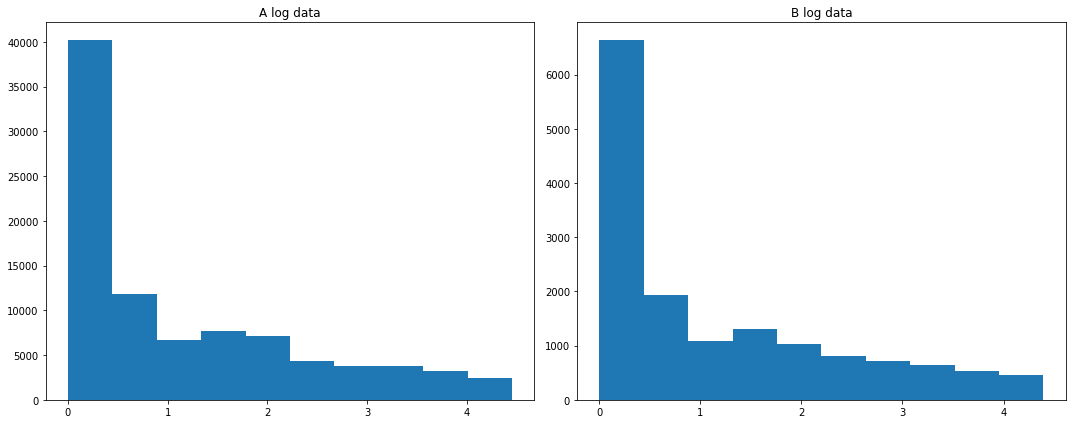

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].hist(np.log(cleared_a))
axes[0].title.set_text('A log data')

axes[1].hist(np.log(cleared_b))
axes[1].title.set_text('B log data')

fig.tight_layout()
plt.show()

Значение pvalue для теста Манна Уитни:

In [17]:
print(mannwhitneyu(cleared_a, cleared_b, alternative='less'))

MannwhitneyuResult(statistic=682238778.5, pvalue=0.09791281756066267)


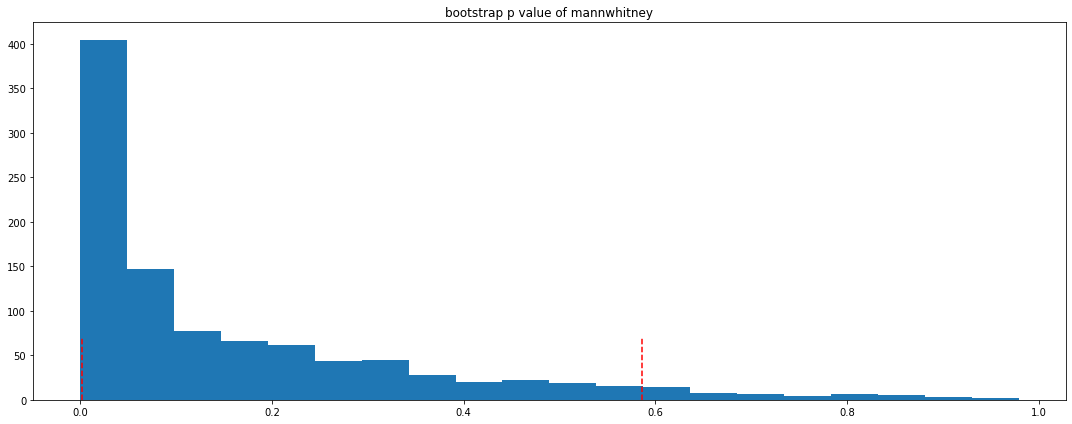

In [18]:
def bootstrap(data_a, data_b, bootstrap_size, n):
    bs = []
    for i in range(n):
        bs_a = np.random.choice(data_a, size=bootstrap_size, replace=True)
        bs_b = np.random.choice(data_b, size=bootstrap_size, replace=True)
        bs.append(mannwhitneyu(bs_a, bs_b, alternative='less')[1])
  
    return bs

bs = bootstrap(cleared_a, cleared_b, 30000, 1000)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

axes.hist(bs, bins = 20)
axes.title.set_text('bootstrap p value of mannwhitney')
axes.vlines(np.percentile(bs, [5, 95]), ymin=0, ymax=70, linestyles='--', color='r')

fig.tight_layout()
plt.show()

В данном случае pvalue ( = 0.0979) находится выше значения высокой статистической значимости (например, 0.01 или 0.05). Поэтому мы не можем заключить наличие различий в двух выборка с достаточной достоверностью. 

**Задание 4**

Есть данные с большой дисперсии у метрики (диспресию метрики можно посчитать для каждой группы). Для их дальнейшего анализа дисперсию необходимо сократить. Как определить, что дисперсия действительно большая? Если она большая, как вы будете ее чистить? Ответ аргументировать и описать.  P.S. Вам может помочь лекция Виталия Черемисинова, где он рассказывал про А/Б тесты

Описание данных: 

* metrics -- значение определенной метрики в сервисе для пользователя (например, количество кликов). 

[Ссылка на данные](https://drive.google.com/file/d/1fc8BGSjDiwbZW6rcr3mMSwAjU2T_BpGW/view?usp=sharing)

*Вместе с ответом на задание приложить код*

In [0]:
data4 = pd.read_csv("test_1_1.csv", sep=';', index_col = 'Unnamed: 0')

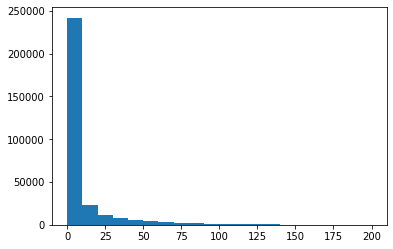

In [20]:
plt.hist(data4.metrics, bins= 20, range=[0, 200])
plt.show()

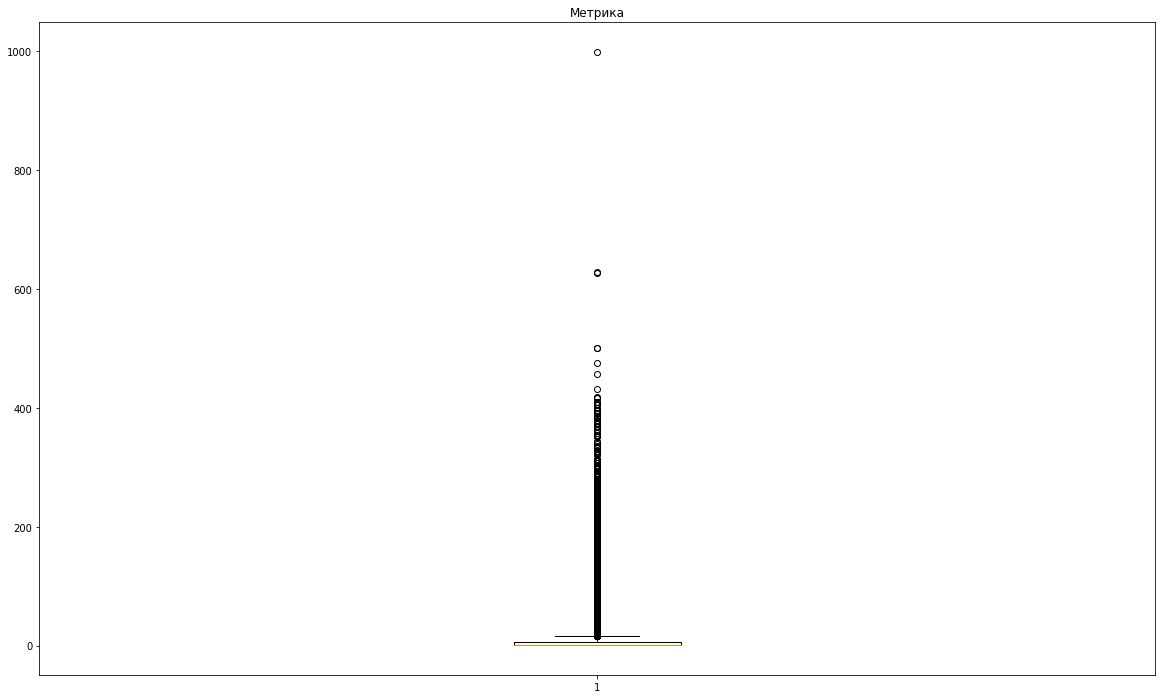

In [21]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))
axes.boxplot(data4.metrics, meanline=True)
axes.title.set_text("Метрика")
plt.show()

In [22]:
print('Дисперсия: ', np.var(data4.metrics))
print('Стандартное отклонение: ', np.std(data4.metrics))

Дисперсия:  511.99656406368365
Стандартное отклонение:  22.627341073658734


In [23]:
print("Перцентили: ", np.percentile(data4.metrics, [0, 50, 95, 96, 98, 100]))

Перцентили:  [  1.   2.  52.  60.  85. 998.]


На Box plot'е видно, что дисперсия большая (точнее видно что у распределения очень длинный хвост) -- при обычной дисперсии не должно быть такого количества точек вне 95го перцентиля. 


Предлагаю 2 способа уменьшить дисперсию:


1.   Удалить выбросы.
2.   Сделать преобразование выборки, например, взять логарифм (это трансформация Бокса-Кокса в данном случае)



In [24]:
cleared = data4[data4.metrics <= 60].metrics
print("Дисперсия без выбросов: ", np.var(cleared))

Дисперсия без выбросов:  116.72949712191138


In [25]:
log_cleared = np.log(cleared)
print("Дисперсия без выбросов c логарифмированием: ", np.var(log_cleared))

Дисперсия без выбросов c логарифмированием:  1.3979418237964487


Ещё один способ сократить дисперсию -- разбиение выборки по децилям:


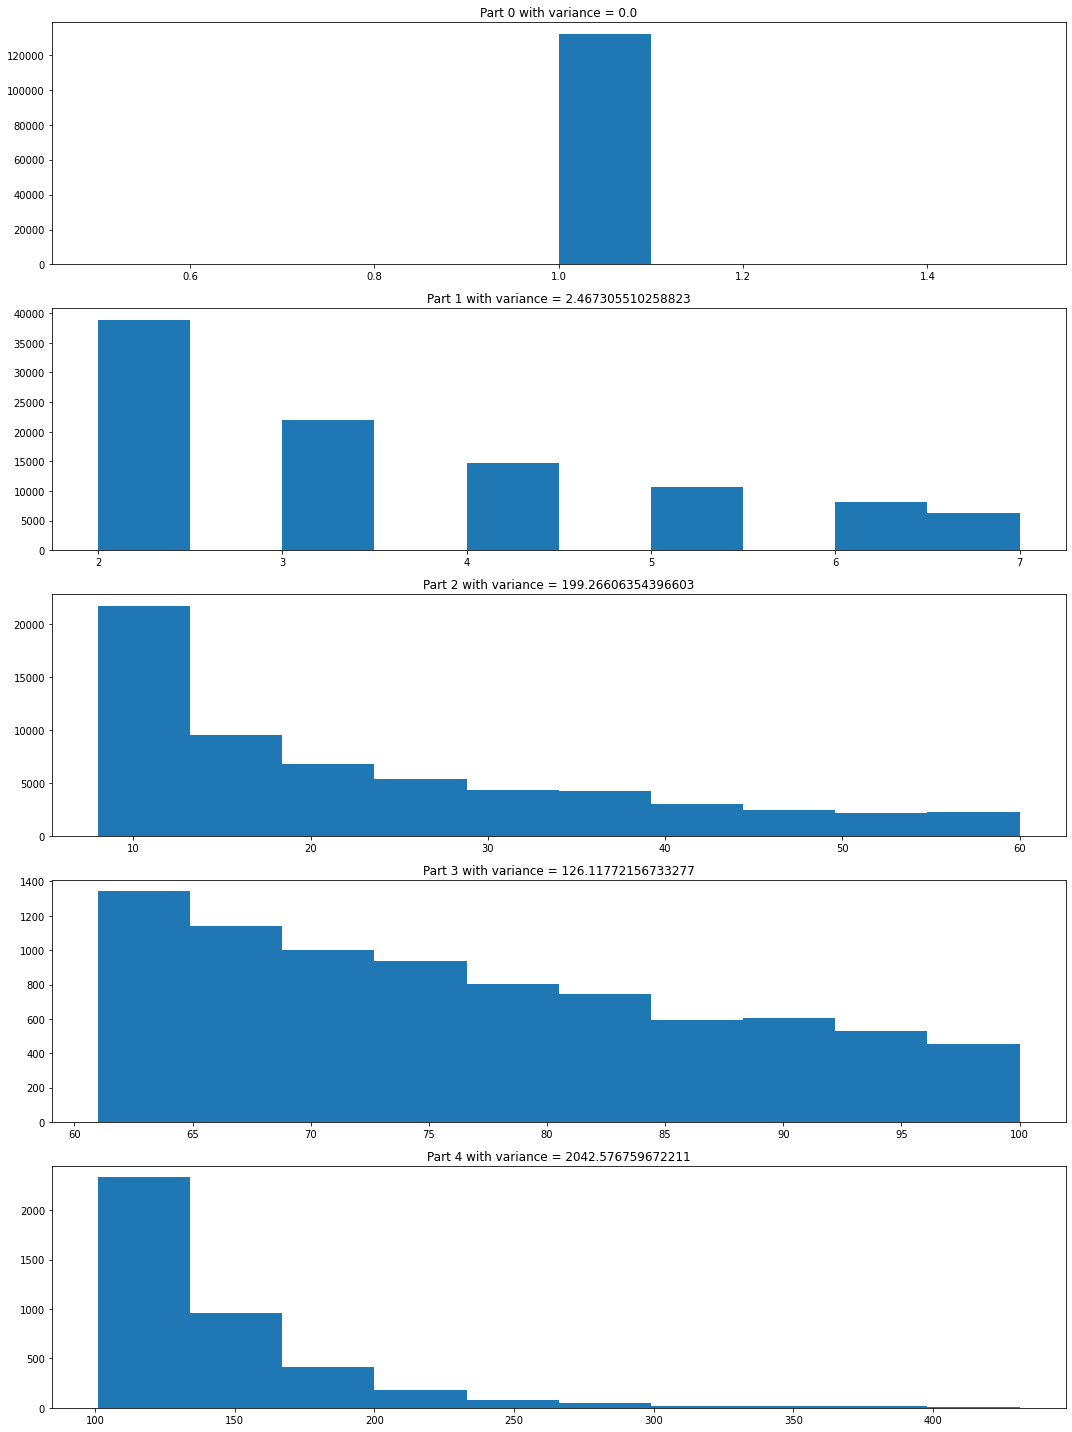

In [26]:
decile = [0, 1, 7, 60, 100, 450]
fig, axes = plt.subplots(nrows=len(decile)-1, ncols=1, figsize=(15, 20))

for i in range(len(decile)-1):
    curr_data = data4[(data4.metrics > decile[i]) & (data4.metrics <= decile[i + 1])].metrics
    axes[i].hist(curr_data, bins = 10)
    axes[i].title.set_text('Part ' + str(i) + ' with variance = ' + str(np.var(curr_data)))


fig.tight_layout()
plt.show()

**Задание 5**

Есть эксперимент с поисковыми подсказками. Вы хотим узнать, как изменился CTR в каждой группе эксперимента.

**Данные**

- id - уникальный идентификатор пользователя
- action -
- view - кол-во просмотров на одну сессию
- variant - вариант a/b теста, где 0 - это версия "A", 1 -  версия "B".

**Задача**

- сформировать метрику для оценки эксперимента
- подобрать критерий под особенности данных
- сделать вывод о значимости эффекта

**Данные** 

[Ссылка на данные](https://www.dropbox.com/s/fdki267uilkfq7l/task5.csv)

In [0]:
data5 = pd.read_csv("task5.csv", sep=',')
data_a = data5[data5.variant == 'A']
data_b = data5[data5.variant == 'B']
data_a_view = data5[data5.variant == 'A'].view
data_b_view = data5[data5.variant == 'B'].view
data_a_action = data5[data5.variant == 'A'].action
data_b_action = data5[data5.variant == 'B'].action

Проверим, что нет пользователей, находящихся одновременно в A и B версиях:

In [28]:
data5.id.unique

<bound method Series.unique of 0         88258
1        109938
2        117644
3        374080
4        662082
         ...   
8186    7706713
8187    7875223
8188    4617329
8189    5394863
8190    7558165
Name: id, Length: 8191, dtype: int64>

In [29]:
data5.id

0         88258
1        109938
2        117644
3        374080
4        662082
         ...   
8186    7706713
8187    7875223
8188    4617329
8189    5394863
8190    7558165
Name: id, Length: 8191, dtype: int64

Посмотрим на данные:

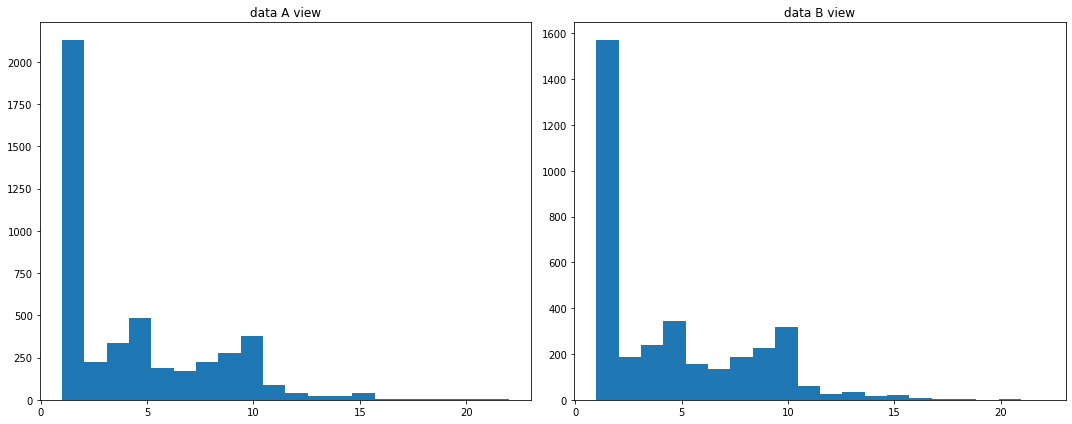

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].hist(data_a_view, bins = 20)
axes[0].title.set_text('data A view')

axes[1].hist(data_b_view, bins = 20)
axes[1].title.set_text('data B view')

fig.tight_layout()
plt.show()

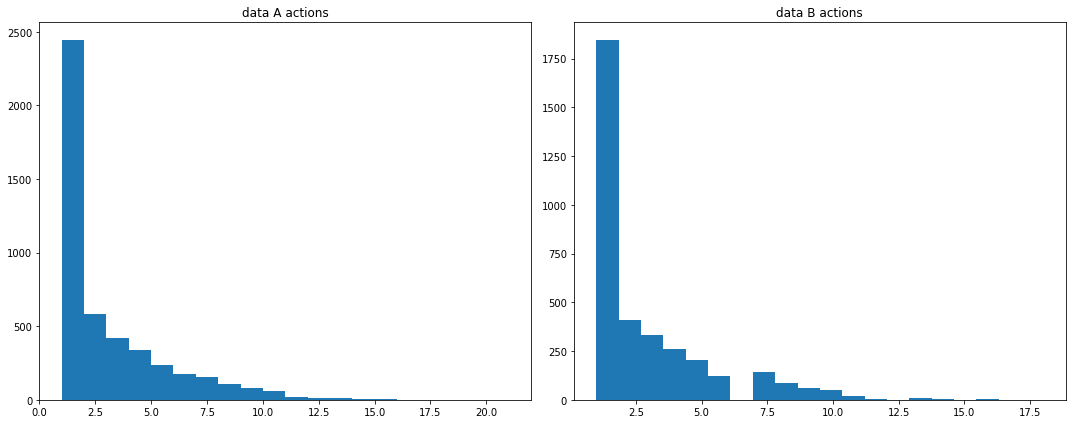

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].hist(data_a_action, bins = 20)
axes[0].title.set_text('data A actions')

axes[1].hist(data_b_action, bins = 20)
axes[1].title.set_text('data B actions')

fig.tight_layout()
plt.show()

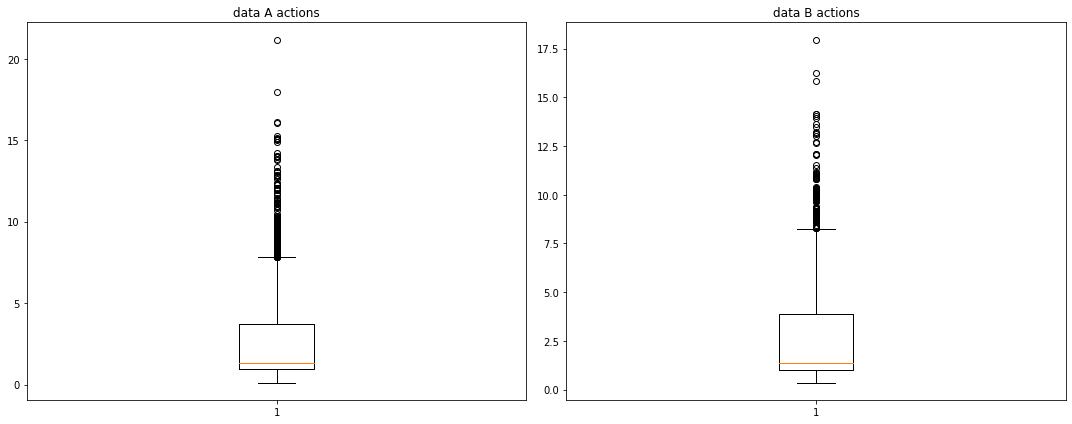

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].boxplot(data_a_action + np.random.normal(0, 0.2, data_a_action.shape[0]), meanline=True)
axes[0].title.set_text('data A actions')

axes[1].boxplot(data_b_action + np.random.normal(0, 0.2, data_b_action.shape[0]), meanline=True)
axes[1].title.set_text('data B actions')

fig.tight_layout()
plt.show()

К данным на последней картинке добавлено немного шума чтобы лучше видеть кол-во выбросов. 

Так как клики это вновь не деньги, то можно безболезненно отбросить часть данных выходящих за какой-то перцентиль.

In [0]:
a_action_cleared = data_a_action[data_a_action < np.percentile(data_a_action, [98][0])]
b_action_cleared = data_b_action[data_b_action < np.percentile(data_b_action, [98][0])]

data_a_cleared = data_a[data_a.action < np.percentile(data5.action, [98][0])]

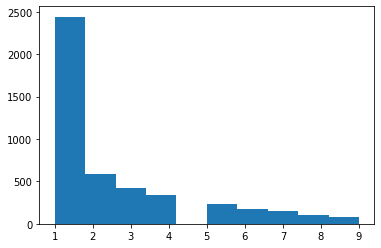

In [34]:
plt.hist(a_action_cleared)
plt.show()

Введём метрику ctr = кол-во кликов пользователя / кол-во просмотров.

In [0]:
data5['ctr'] = data5['action'] / (data5['view'] + 1e-10)
a_ctr = data5[data5.variant == 'A'].ctr
b_ctr = data5[data5.variant == 'B'].ctr

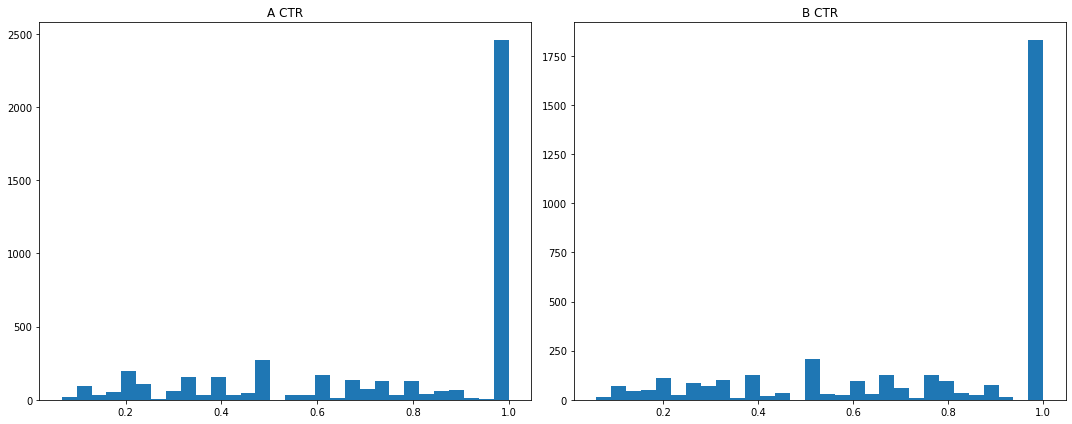

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].hist(a_ctr, bins = 30)
axes[0].title.set_text('A CTR')

axes[1].hist(b_ctr, bins = 30)
axes[1].title.set_text('B CTR')

fig.tight_layout()
plt.show()

Распределения не похожи ни на одно стандартное. 

In [37]:
print('A ctr mean:', np.mean(a_ctr))
print('B ctr mean:', np.mean(b_ctr))

A ctr mean: 0.7615838991011978
B ctr mean: 0.7564976441165369


In [38]:
print('A ctr mean without all-clicks users:', np.mean(a_ctr[a_ctr < 1.0]))
print('B ctr mean without all-clicks users:', np.mean(b_ctr[b_ctr < 1.0]))

A ctr mean without all-clicks users: 0.7615838991011978
B ctr mean without all-clicks users: 0.7564976441165369


Видим, что простой взгляд на среднее не даёт оценки.

Посмотрим также на общий ctr = все клики / все просмотры:

In [39]:
print("Overall ctr A:", np.sum(data_a_action) / np.sum(data_a_view))
print("Overall ctr B:", np.sum(data_b_action) / np.sum(data_b_view))

Overall ctr A: 0.6092203122691228
Overall ctr B: 0.6061197506768243


Такое отличие общего ctr и среднего по пользователям, говорит о том, что пользователи с высоким ctr также имели высокое число просмотров. 

In [40]:
print("Correlation of action and view in group A:", np.corrcoef(data_a_action, data_a_view)[1][0])
print("Correlation of action and view in group B:", np.corrcoef(data_b_action, data_b_view)[1][0])

Correlation of action and view in group A: 0.7495977683450313
Correlation of action and view in group B: 0.7407513036884875


Видим, что коэффициент корреляции действительно высокий. Более того, заметно существунное отличие -- в группе A корреляция action и view выше на 0.09.

In [0]:
def get_cumulative(data):
    cumulative_mean_a = []
    cumulative_total_a = []

    cumulative_mean_b = []
    cumulative_total_b = []

    data_a = data[data.variant == 'A']
    data_b = data[data.variant == 'B']

    for i in range(1, data_a.shape[0] + 1):
        current_data_a = data_a[0:i]
        cumulative_mean_a.append(np.mean(current_data_a.ctr))
        cumulative_total_a.append(np.sum(current_data_a.action) / np.sum(current_data_a.view))

    for i in range(1, data_b.shape[0] + 1):
        current_data_b = data_b[0:i]
        cumulative_mean_b.append(np.mean(current_data_b.ctr))
        cumulative_total_b.append(np.sum(current_data_b.action) / np.sum(current_data_b.view))

    return cumulative_mean_a, cumulative_mean_b, cumulative_total_a, cumulative_total_b

cumulative_mean_a, cumulative_mean_b, cumulative_total_a, cumulative_total_b = get_cumulative(data5)

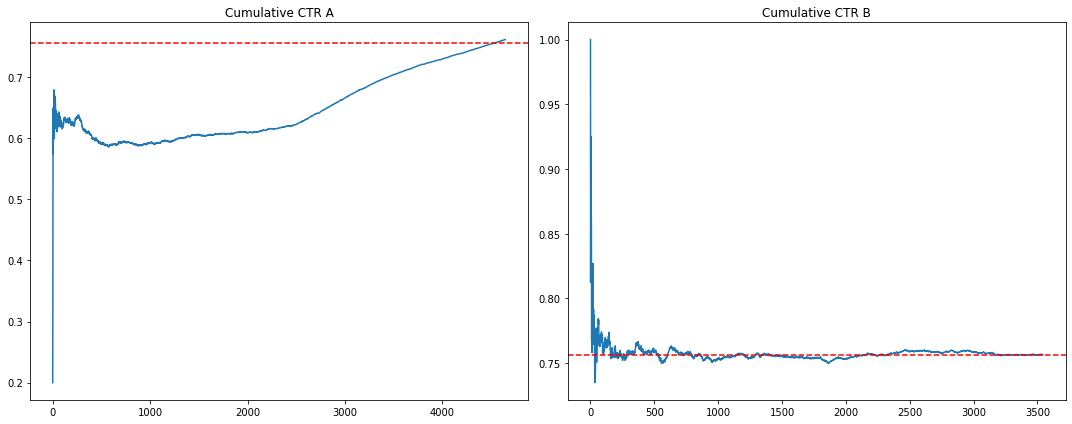

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(cumulative_mean_a)
axes[0].axhline(y=cumulative_mean_b[-1], color='r', linestyle='--')
axes[0].title.set_text('Cumulative CTR A')

axes[1].plot(cumulative_mean_b)
axes[1].axhline(y=cumulative_mean_b[-1], color='r', linestyle='--')
axes[1].title.set_text('Cumulative CTR B')

fig.tight_layout()
plt.show()

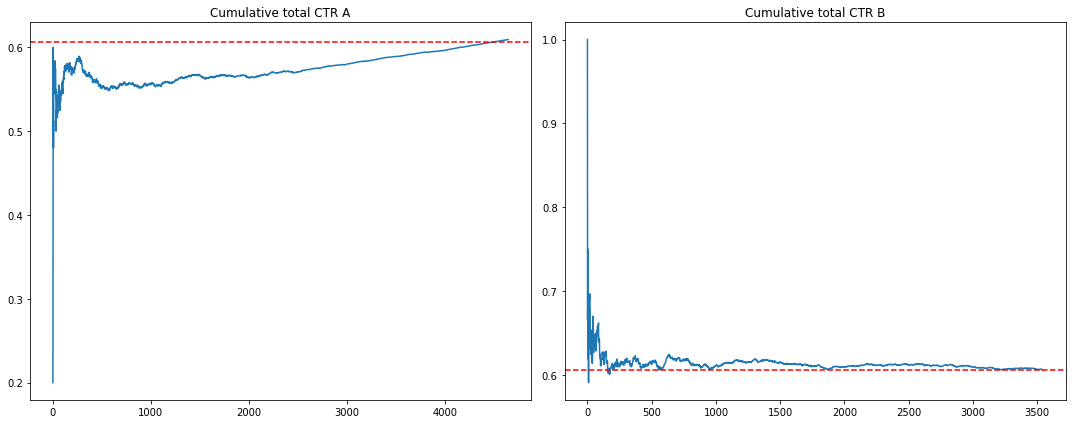

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].plot(cumulative_total_a)
axes[0].axhline(y=cumulative_total_b[-1], color='r', linestyle='--')
axes[0].title.set_text('Cumulative total CTR A')

axes[1].plot(cumulative_total_b)
axes[1].axhline(y=cumulative_total_b[-1], color='r', linestyle='--')
axes[1].title.set_text('Cumulative total CTR B')

fig.tight_layout()
plt.show()

Красные линии - последние значения для варианта B (для сравнения графиков с разными шкалами)

Нам неизвестно отсортированы ли данные по времени; **если отсортированы, то вариант A доставляет ctr растущий со временем, в то время как вариант B тренда не имеет, поэтому стоит оставить вариант A.** 

Если даные не отсортированы по времени, то будет делать обычный bootstrap для ctr. 

In [0]:
def bootstrap(data_a, data_b, bootstrap_size, n):
    bs = []
    for i in range(n):
        bs_a = np.random.choice(data_a, size=bootstrap_size, replace=True)
        bs_b = np.random.choice(data_b, size=bootstrap_size, replace=True)
        bs.append(mannwhitneyu(bs_a, bs_b, alternative='greater')[1])
  
    return bs

n = 1500
bootstrap_size = 3000

bs = bootstrap(a_ctr, b_ctr, bootstrap_size, n)

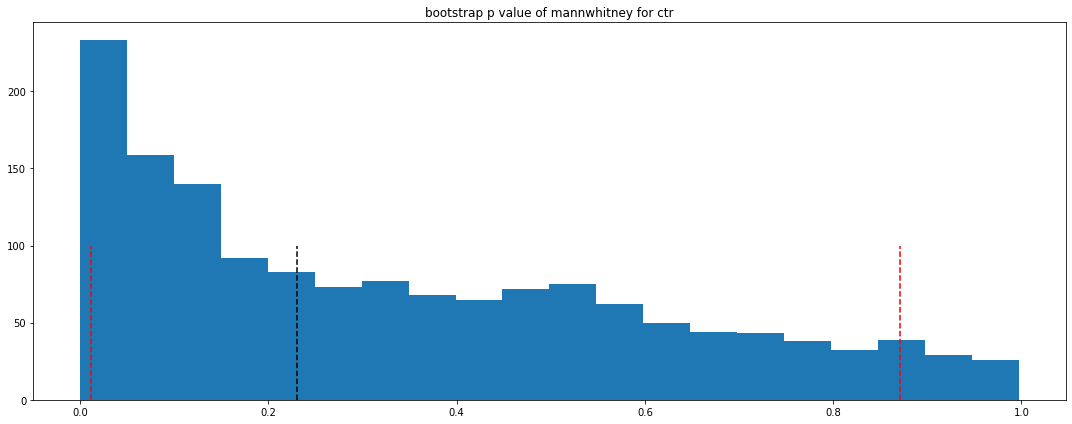

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))

axes.hist(bs, bins = 20)
axes.title.set_text('bootstrap p value of mannwhitney for ctr')
axes.vlines(np.percentile(bs, [5, 95]), ymin=0, ymax=100, linestyles='--', color='r')
axes.vlines(mannwhitneyu(a_ctr, b_ctr, alternative='greater')[1], ymin=0, ymax=100, linestyles='--', color='black')

fig.tight_layout()
plt.show()

Подход с использованием Mann-Whitney не позволяет отвергнуть гипотезу о том, что средний ctr в выборках отличается. Однако это не отменяет предыдущих выводов о случае, в котором выборка упорядочена по времени.